In [1]:
from importlib import reload
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='whitegrid')
import ard_logging
import logging
ard_logging.init()
LOG = logging.getLogger(__name__)
LOG.info('Hello from notebook')

2022-06-28 17:50:31,889:    INFO:      ard_logging: MainProcess 7948: Logging initialized.
2022-06-28 17:50:31,889:    INFO:         __main__: MainProcess 7948: Hello from notebook


In [3]:
import ard_fit_pipelines as fp
#reload(fp.core); reload(fp.transforms); reload(fp)
#import ard_fit_pipelines.core as fpc
#import ard_fit_pipelines.transforms as fpt

logging.getLogger('ard_fit_pipelines').setLevel(logging.INFO)
#reload(fpc)

In [ ]:
fp.

In [4]:
from pydataset import data

In [5]:
df = data('diamonds')
data('diamonds', show_doc=True)

diamonds

PyDataset Documentation (adopted from R Documentation. The displayed examples are in R)

## Prices of 50,000 round cut diamonds

### Description

A dataset containing the prices and other attributes of almost 54,000
diamonds. The variables are as follows:

### Usage

    data(diamonds)

### Format

A data frame with 53940 rows and 10 variables

### Details

  * price. price in US dollars (\$326–\$18,823) 

  * carat. weight of the diamond (0.2–5.01) 

  * cut. quality of the cut (Fair, Good, Very Good, Premium, Ideal) 

  * colour. diamond colour, from J (worst) to D (best) 

  * clarity. a measurement of how clear the diamond is (I1 (worst), SI1, SI2, VS1, VS2, VVS1, VVS2, IF (best)) 

  * x. length in mm (0–10.74) 

  * y. width in mm (0–58.9) 

  * z. depth in mm (0–31.8) 

  * depth. total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43–79) 

  * table. width of top of diamond relative to widest point (43–95) 




In [6]:
index_all = set(df.index)
index_in = set(np.random.choice(df.index, size=int(len(df)/2), replace=False))
index_out = index_all - index_in
len(index_all), len(index_in), len(index_out)
df_in = df.loc[list(index_in)]
df_out = df.loc[list(index_out)]
df_in.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48


In [7]:
df_out.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39
11,0.30,Good,J,SI1,64.0,55.0,339,4.25,4.28,2.73


array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

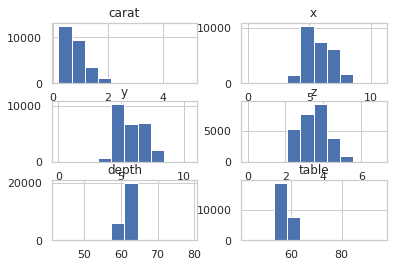

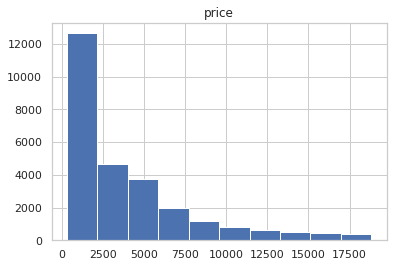

In [9]:
FEATURES = ['carat', 'x', 'y', 'z', 'depth', 'table']
df_in[FEATURES].hist();
df_in[['price']].hist()

In [10]:
def standardize(cols):
    return fp.Pipeline([
        fp.Winsorize(cols, limit=0.05),
        fp.ZScore(cols),
        fp.ImputeConstant(cols, 0.0),
        fp.Clip(cols, upper=2, lower=-2)
    ])

FEATURES = ['carat', 'x', 'y', 'z', 'depth', 'table']

pipeline = fp.Pipeline([
    fp.CopyColumns('price', 'price_train'),
    fp.Pipe(['carat', 'price_train'], np.log1p),
    standardize(FEATURES + ['price_train'])
])
pipeline

Pipeline(transforms=[CopyColumns(cols=['price'], dest_cols=['price_train']), Pipe(cols=['carat', 'price_train'], apply_fun=<ufunc 'log1p'>), Pipeline(transforms=[Winsorize(cols=['carat', 'x', 'y', 'z', 'depth', 'table', 'price_train'], limit=0.05), ZScore(cols=['carat', 'x', 'y', 'z', 'depth', 'table', 'price_train'], w_col=None), ImputeConstant(cols=['carat', 'x', 'y', 'z', 'depth', 'table', 'price_train'], value=0.0), Clip(cols=['carat', 'x', 'y', 'z', 'depth', 'table', 'price_train'], upper=2, lower=-2)])])

In [ ]:
# call-chain syntax...

def standardize(cols):
    return (
        fp.Pipeline()
        .winsorize(cols, limit=0.05)
        .z_score(cols)
        .impute_constant(cols, 0.)
        .clip(cols, upper=2, lower=-2)
    )

FEATURES = ['carat', 'x', 'y', 'z', 'depth', 'table']

pipeline = (
    fpc.Pipeline()
    .copy_columns('price', 'price_train')
    .pipe(['carat', 'price_train'], np.log1p)
    .then(standardize(FEATURES + ['price_train']))
)

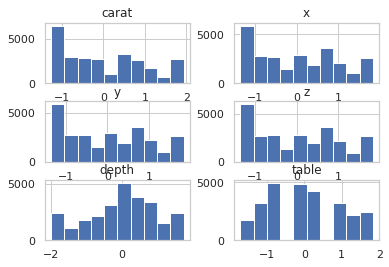

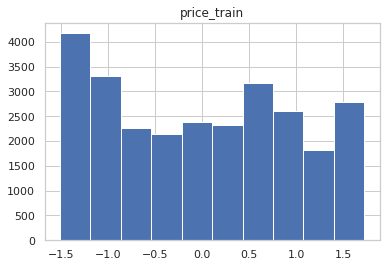

In [11]:
fit_pipeline = pipeline.fit(df_in)
result_in = fit_pipeline.apply(df_in)

result_in[FEATURES].hist();
result_in[['price_train']].hist();

In [12]:
fit_pipeline.state()

[FitCopyColumns(cols=['price'], dest_cols=['price_train'], <26970 rows of fitting data>),
 FitPipe(cols=['carat', 'price_train'], apply_fun=<ufunc 'log1p'>, <26970 rows of fitting data>),
 FitPipeline(transforms=[Winsorize(cols=['carat', 'x', 'y', 'z', 'depth', 'table', 'price_train'], limit=0.05), ZScore(cols=['carat', 'x', 'y', 'z', 'depth', 'table', 'price_train'], w_col=None), ImputeConstant(cols=['carat', 'x', 'y', 'z', 'depth', 'table', 'price_train'], value=0.0), Clip(cols=['carat', 'x', 'y', 'z', 'depth', 'table', 'price_train'], upper=2, lower=-2)], <26970 rows of fitting data>)]

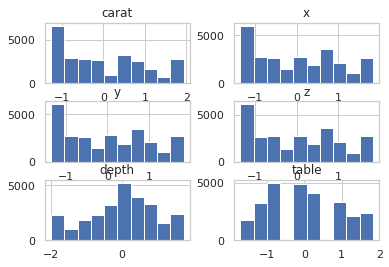

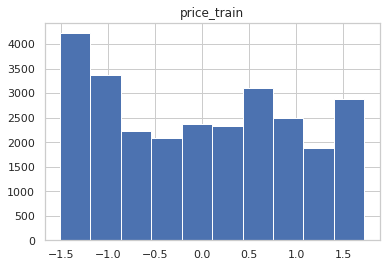

In [13]:
result_out = fit_pipeline.apply(df_out)
result_out[FEATURES].hist();
result_out[['price_train']].hist();